In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay

preparar datos

In [2]:
# Carga de datos
df = pd.read_csv("dataset/gas_turbine_fault_detection_simulated3.csv")  # ajusta ruta/nombre

# Nos quedamos solo con las muestras con fallo
df_fault = df[df["Fault"] == 1].copy()

# Eliminamos columnas que no deben usarse como features
cols_drop = ["Turbine ID", "TTC", "Fault", "Fault Mode"]  # ajusta nombres exactos
X = df_fault.drop(columns=cols_drop)
y = df_fault["Fault Mode"]  # multiclase

# Train/test estratificado por tipo de fallo
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

graficar datos

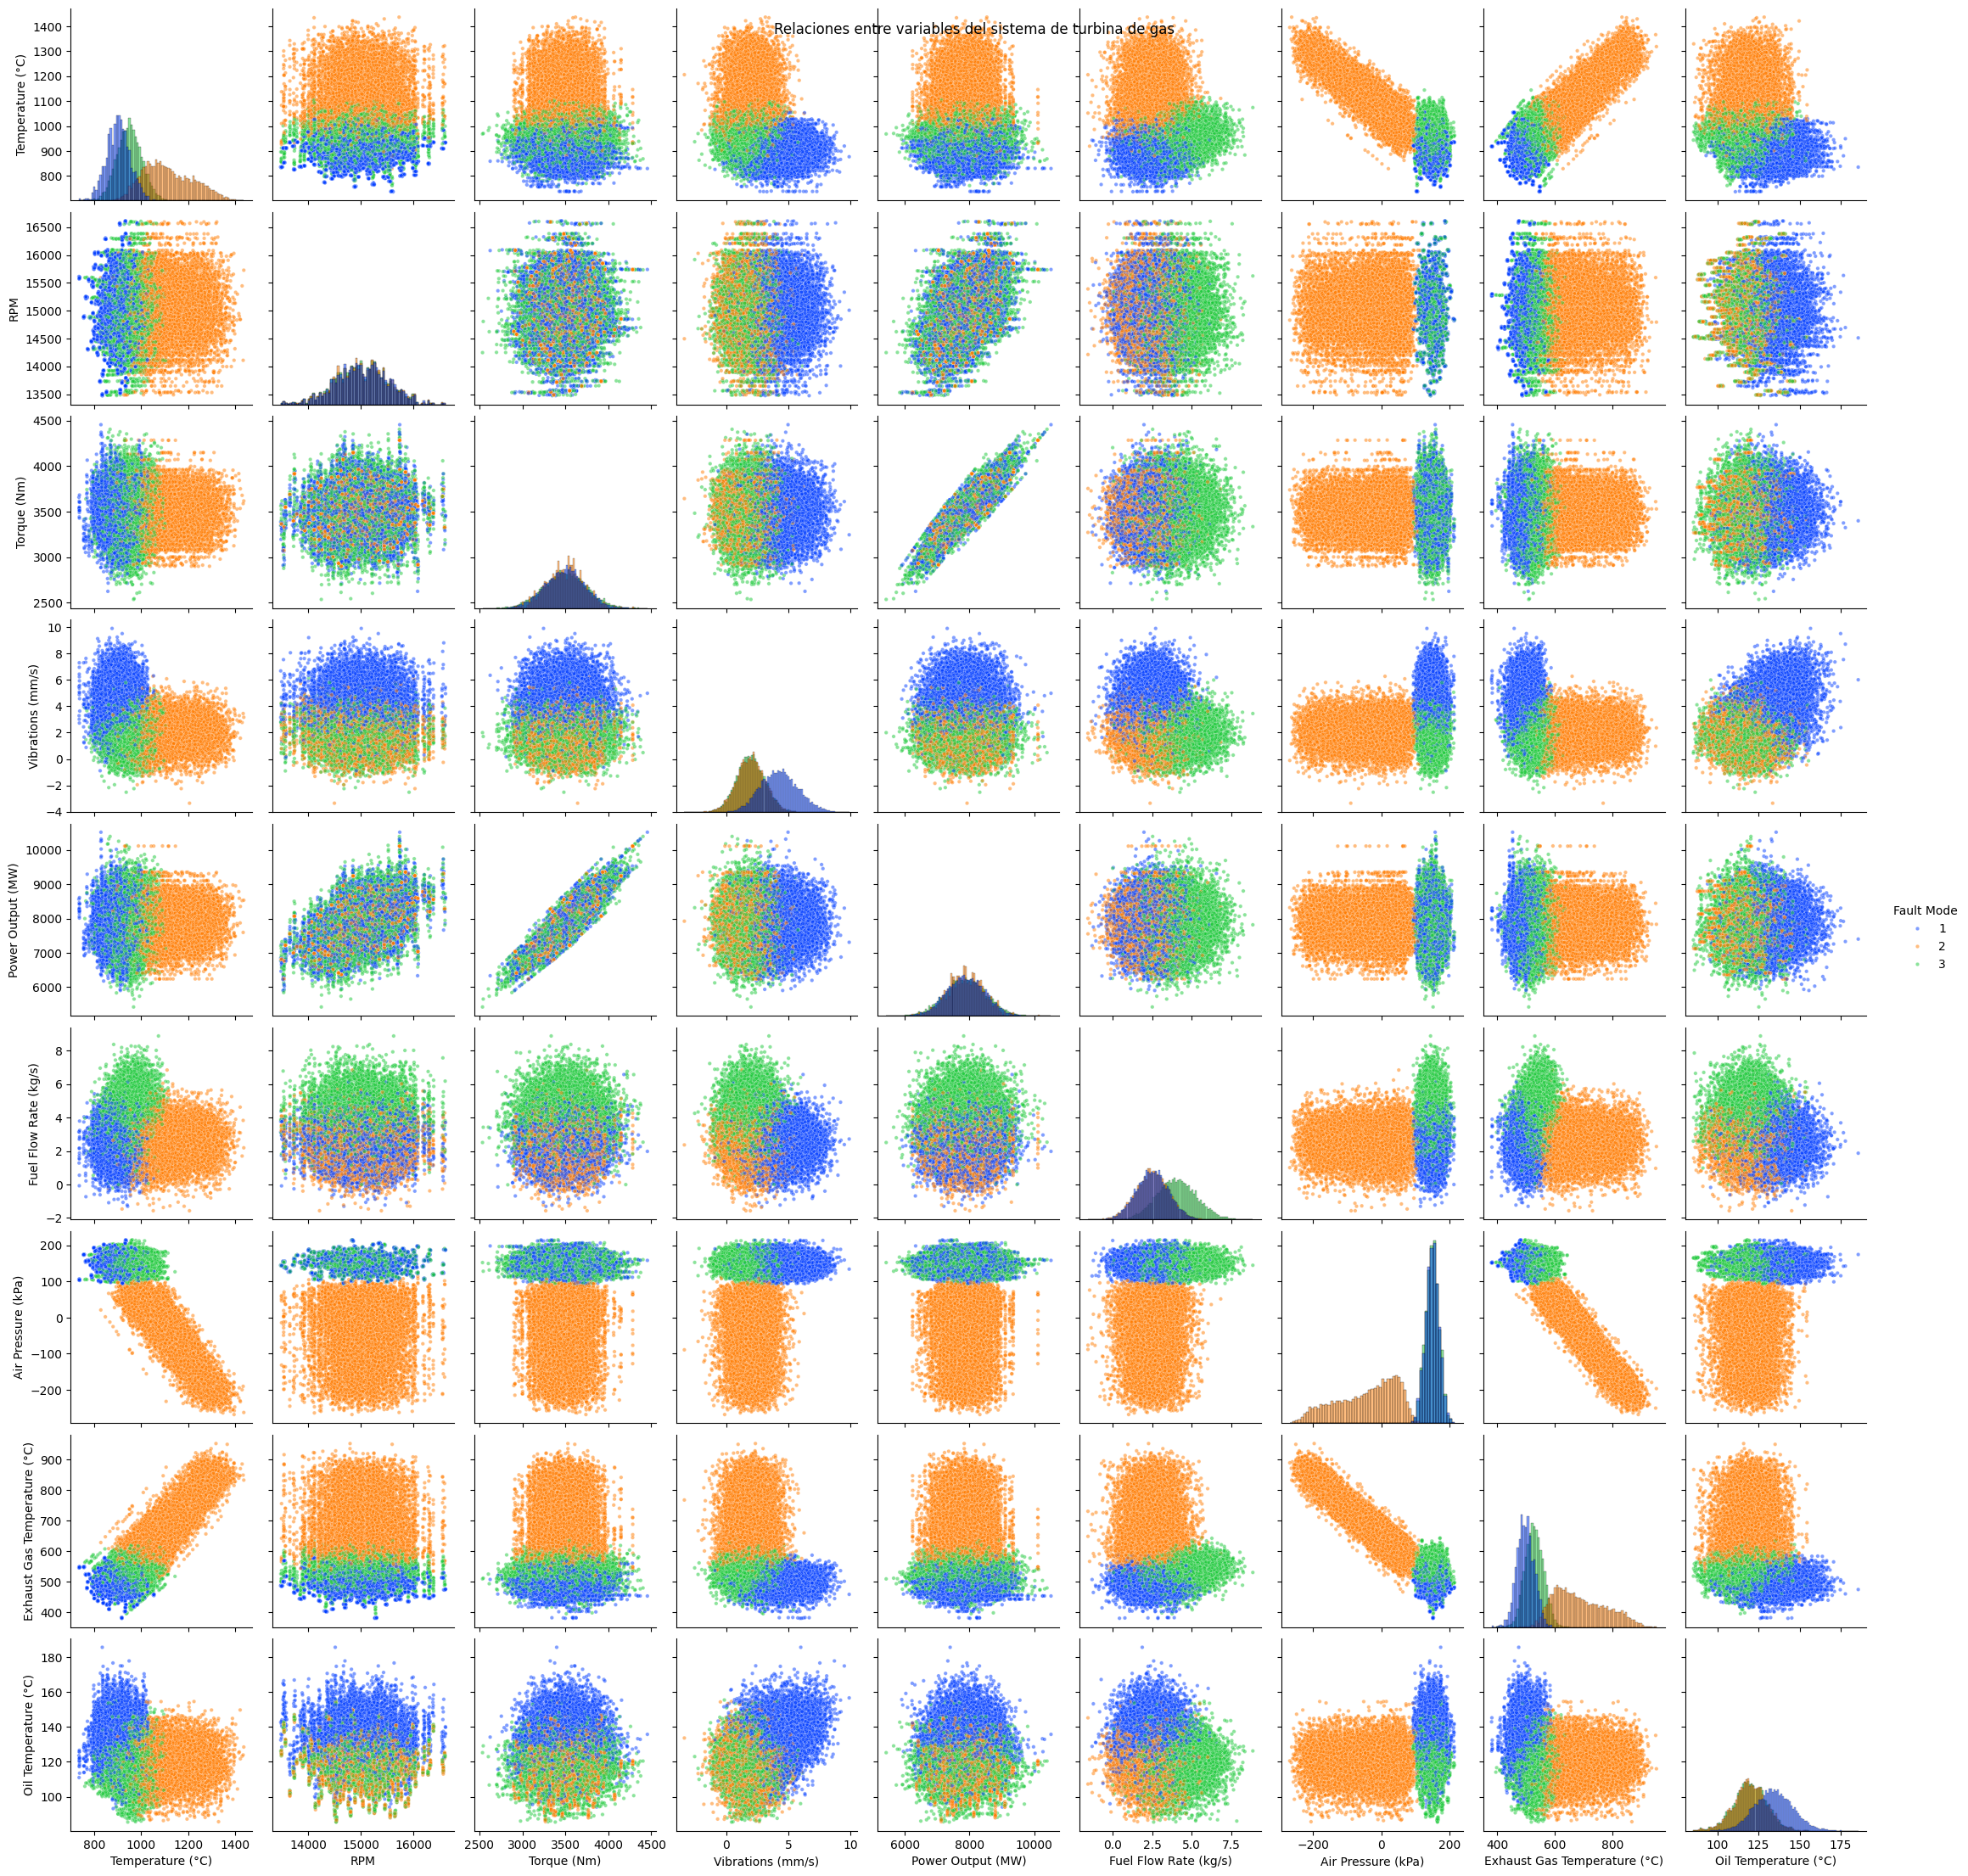

In [ ]:
include_cols = [col for col in df_fault.columns 
                if col not in ['Fault', 'Turbine ID', 'TTC']]

sns.pairplot(df_fault[include_cols], diag_kind="hist", hue="Fault Mode", plot_kws={'alpha': 0.5, 's': 10}, palette='bright')
plt.suptitle("Relaciones entre variables del sistema de turbina de gas")
plt.show()

gridsearch con pipeline usando metrica f1-macro

In [3]:
# Métrica principal: F1 macro (todas las clases por igual)
f1_macro = make_scorer(f1_score, average="macro")

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

param_grid = [
    {
        "clf": [LogisticRegression(max_iter=5000)],
        "clf__C": [0.01, 0.1, 1, 5, 10],      
        'clf__penalty': ['l2', None],                  
        'clf__solver': ['lbfgs', 'newton-cg','sag', 'newton-cholesky'], 
        "clf__class_weight": [None, "balanced"]                
    },
    {
        "clf": [LogisticRegression(max_iter=5000)],
        "clf__C": [0.01, 0.1, 1, 5, 10],      
        'clf__penalty': ['l1', 'l2'],                 
        'clf__solver': ['liblinear'],   
        "clf__class_weight": [None, "balanced"]            
    },
    {
        "clf": [LogisticRegression(max_iter=5000)],
        "clf__C": [0.01, 0.1, 1, 5, 10],      
        'clf__penalty': ['elasticnet'],
        'clf__l1_ratio': [0, 0.5, 1],                
        'clf__solver': ['saga'],    
        "clf__class_weight": [None, "balanced"]            
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=f1_macro,        # métrica que optimiza
    cv=5,                    # 5-fold CV
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1_macro CV:", grid.best_score_)


Fitting 5 folds for each of 130 candidates, totalling 650 fits
Mejores hiperparámetros: {'clf': LogisticRegression(max_iter=5000), 'clf__C': 5, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor F1_macro CV: 0.9477740852968818


In [4]:
best_clf = grid.best_estimator_

In [5]:
results_df = pd.DataFrame(grid.cv_results_)
results_df.columns = [col.replace('param_clf__', '').replace('param_', '') for col in results_df.columns]
results_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.068309      0.008474         0.006336        0.000377   
1       0.099486      0.011907         0.006536        0.000313   
2       0.141868      0.017760         0.005808        0.000664   
3       0.153382      0.006943         0.005279        0.000616   
4       0.233246      0.034597         0.005583        0.000604   

                                 clf     C class_weight penalty  \
0  LogisticRegression(max_iter=5000)  0.01         None      l2   
1  LogisticRegression(max_iter=5000)  0.01         None      l2   
2  LogisticRegression(max_iter=5000)  0.01         None      l2   
3  LogisticRegression(max_iter=5000)  0.01         None      l2   
4  LogisticRegression(max_iter=5000)  0.01         None    None   

            solver  l1_ratio  ... mean_test_score  std_test_score  \
0            lbfgs       NaN  ...        0.941357        0.003627   
1        newton-cg       NaN  ...        0.941236        0.003583   
2              sag       NaN  ...        0.941317        0.003605   
3  newton-cholesky       NaN  ...        0.941317        0.003605   
4            lbfgs       NaN  ...        0.947439        0.001418   

   rank_test_score  split0_train_score  split1_train_score  \
0              120            0.941693            0.940745   
1              125            0.941642            0.940845   
2              121            0.941642            0.940795   
3              121            0.941642            0.940795   
4               18            0.946578            0.946984   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.942544            0.942792            0.940140   
1            0.942444            0.942692            0.940192   
2            0.942444            0.942842            0.940192   
3            0.942444            0.942842            0.940242   
4            0.948195            0.948443            0.947437   

   mean_train_score  std_train_score  
0          0.941583         0.001018  
1          0.941563         0.000944  
2          0.941583         0.000989  
3          0.941593         0.000975  
4          0.947527         0.000705  

[5 rows x 26 columns]

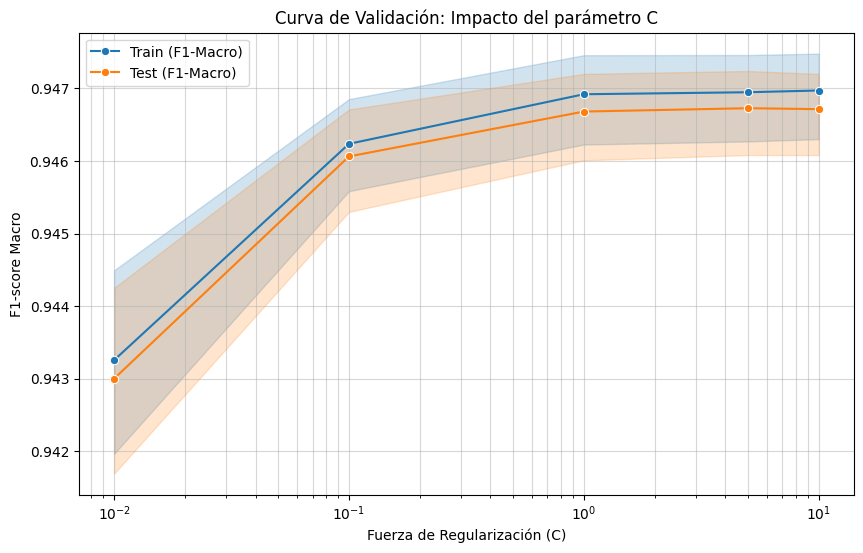

In [6]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df, x='C', y='mean_train_score', label='Train (F1-Macro)', marker='o')
sns.lineplot(data=results_df, x='C', y='mean_test_score', label='Test (F1-Macro)', marker='o')

plt.xscale('log') 
plt.title('Curva de Validación: Impacto del parámetro C')
plt.xlabel('Fuerza de Regularización (C)')
plt.ylabel('F1-score Macro')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

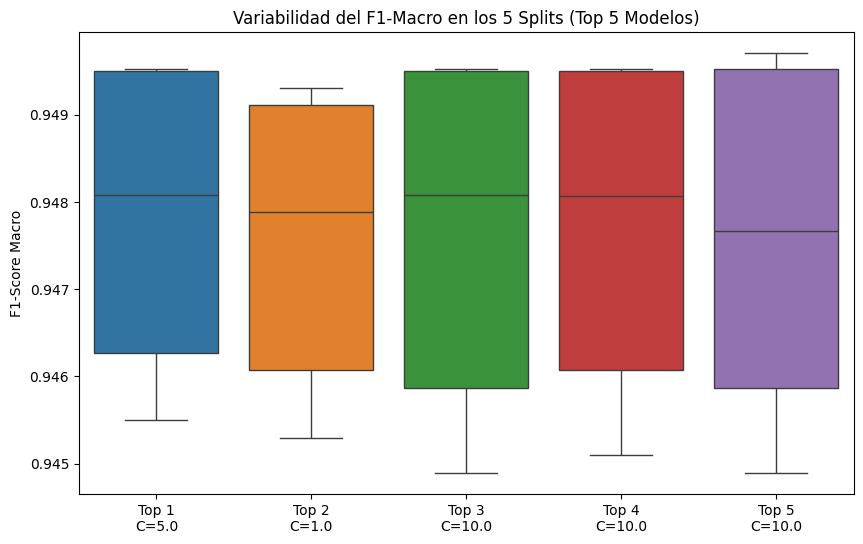

In [7]:
top_5_idx = results_df['rank_test_score'].nsmallest(5).index
top_5_models = results_df.loc[top_5_idx]

split_cols = [f'split{i}_test_score' for i in range(5)]
df_splits = top_5_models[split_cols].transpose()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_splits)
plt.xticks(range(5), [f"Top {i+1}\nC={c}" for i, c in enumerate(top_5_models['C'])])
plt.title('Variabilidad del F1-Macro en los 5 Splits (Top 5 Modelos)')
plt.ylabel('F1-Score Macro')
plt.show()

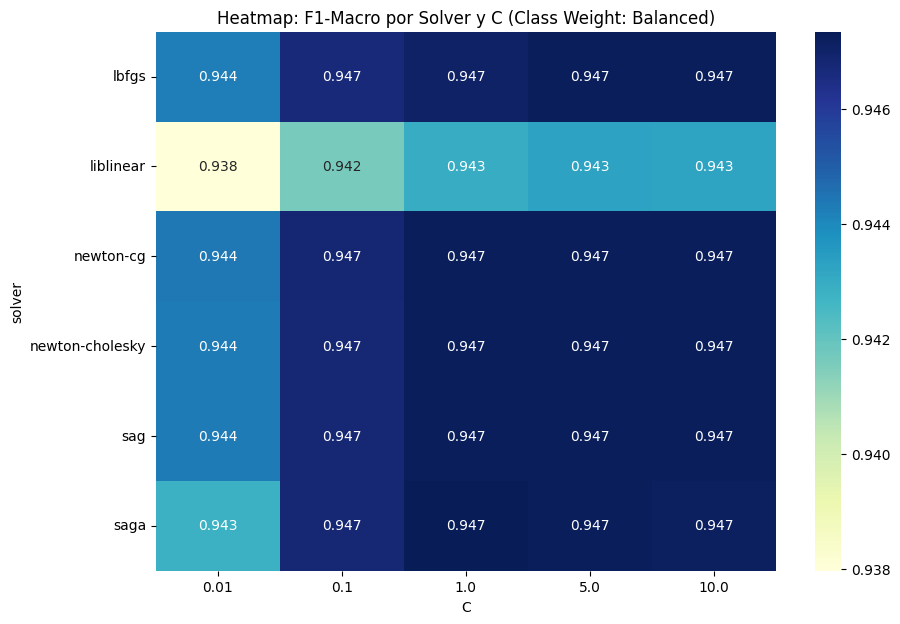

In [8]:
subset = results_df[results_df['class_weight'] == 'balanced']

pivot = subset.pivot_table(index='solver', columns='C', values='mean_test_score')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Heatmap: F1-Macro por Solver y C (Class Weight: Balanced)')
plt.show()

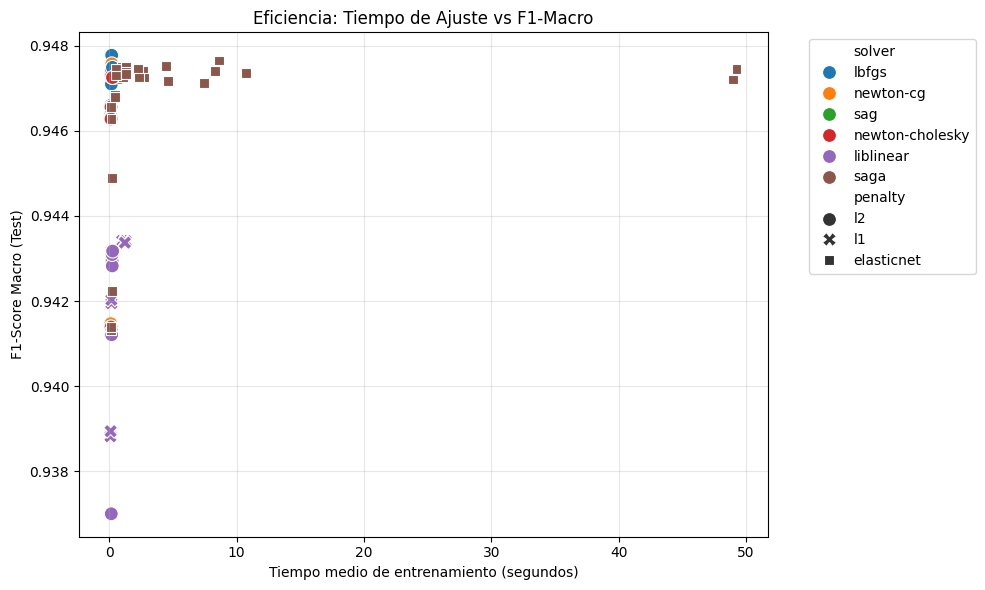

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='mean_fit_time', y='mean_test_score', 
                hue='solver', style='penalty', s=100)

plt.title('Eficiencia: Tiempo de Ajuste vs F1-Macro')
plt.xlabel('Tiempo medio de entrenamiento (segundos)')
plt.ylabel('F1-Score Macro (Test)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

curva de aprendizaje del modelo

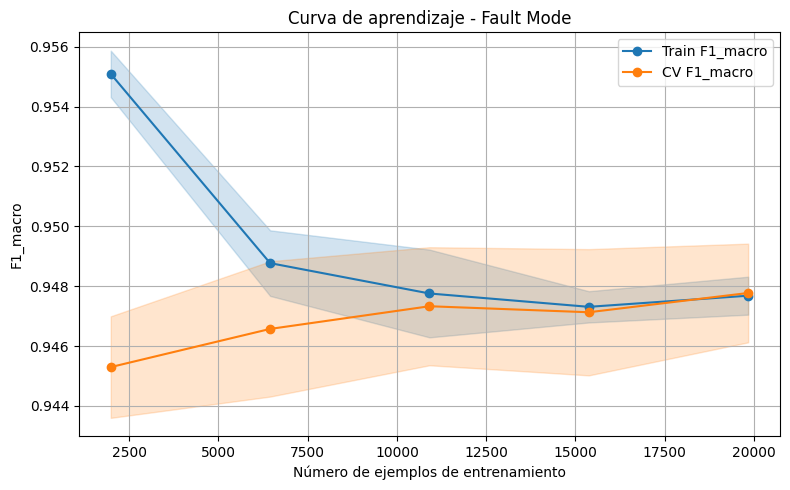

In [10]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_clf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, ..., 100%
    cv=5,
    scoring=f1_macro,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "o-", color="tab:blue", label="Train F1_macro")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color="tab:blue")
plt.plot(train_sizes, val_mean, "o-", color="tab:orange", label="CV F1_macro")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color="tab:orange")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("F1_macro")
plt.title("Curva de aprendizaje - Fault Mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

evaluacion del modelo en test

F1_macro en test: 0.9467316285927149
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.92      0.92      0.92      2059
           2       1.00      1.00      1.00      2058
           3       0.92      0.92      0.92      2083

    accuracy                           0.95      6200
   macro avg       0.95      0.95      0.95      6200
weighted avg       0.95      0.95      0.95      6200

Matriz de confusión:


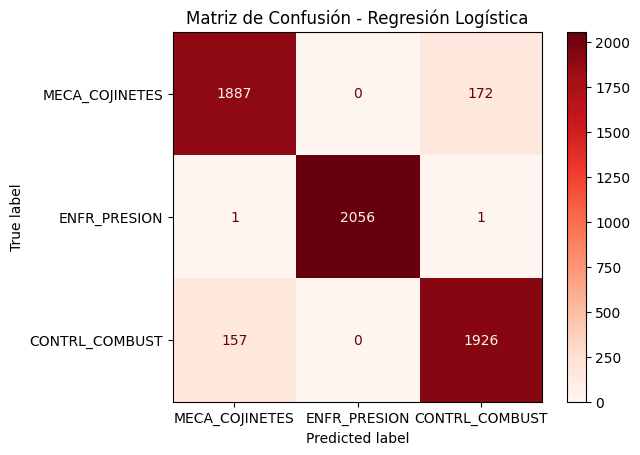

In [11]:
y_pred = best_clf.predict(X_test)

print("F1_macro en test:",
      f1_score(y_test, y_pred, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['MECA_COJINETES', 'ENFR_PRESION', 'CONTRL_COMBUST'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

importancia de los coeficientes para el modelo

[np.float64(3.7025629416444805), np.float64(1.7263924000276996), np.float64(0.42823786465353686), np.float64(0.2280989281676283), np.float64(0.10976982741789683), np.float64(0.3856815722442881), np.float64(1.152727139042928), np.float64(1.526969988014205), np.float64(6.802850424212755)]


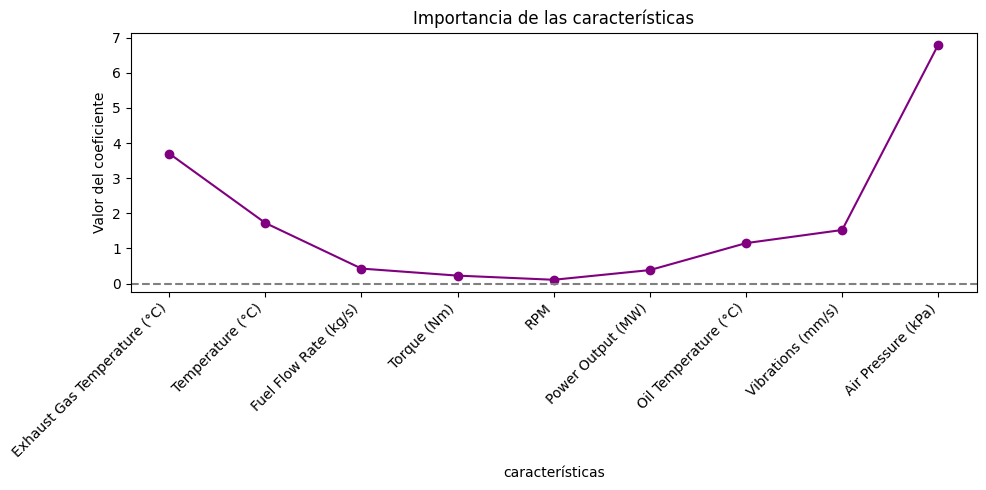

In [12]:
coeficientes = best_clf[-1].coef_
feature_importance = best_clf.named_steps['clf'].coef_[0]

feature_names = df_fault.columns.to_list()

sorted_idx = np.argsort(feature_importance)
sorted_features = [feature_names[i] for i in sorted_idx]

sorted_importance = list(map(abs, feature_importance[sorted_idx]))
print(sorted_importance)

plt.figure(figsize=(10, 5))
plt.plot(range(len(sorted_importance)), sorted_importance, marker="o", linestyle="-", color="purple")
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Importancia de las características")
plt.ylabel("Valor del coeficiente")
plt.xlabel("características")
plt.tight_layout()
plt.show()

In [13]:
from models.manage_models import save_model
# Guardar el mejor modelo (el Pipeline completo)
paths = save_model(
    model=grid.best_estimator_, 
    model_name='probl2_logistic_regression',
    save_path='models/',
    metadata={
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'scorer': 'f1_macro'
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl2_logistic_regression_20251217_090528.joblib
